# Predicting Bounding Boxes

Welcome to Course 3, Week 1 Programming Assignment!

In this week's assignment, you'll build a model to predict bounding boxes around images.  
- You will use transfer learning on any of the pre-trained models available in Keras.
- You'll be using the [Caltech Birds - 2010](http://www.vision.caltech.edu/visipedia/CUB-200.html) dataset.


### How to submit your work
Notice that there is not a "submit assignment" button in this notebook.  

To check your work and get graded on your work, you'll train the model, save it and then upload the model to Coursera for grading.

- [Initial steps](#0)
  - [0.1 Set up your Colab](#0-1)
  - [0.2 Choose the GPU Runtime](#0-2)
  - [0.3 Imports](#0-3)
  - [0.4 Download and Extract the Dataset](#0-4)
- [1. Visualization Utilities](#1)
  - [1.1 Bounding Boxes Utilities](#1-1)
  - [1.2 Data and Predictions Utilities](#1-2)
- [2. Preprocessing and Loading the Dataset](#2)
  - [2.1 Preprocessing Utilities](#2-1)
  - [2.2 Visualize the prepared Data](#2-2)
  - [2.3 Loading the Dataset](#2-3)
- [3. Define the Network](#3)
  - [Exercise 1](#ex-01)
  - [Exercise 2](#ex-02)
  - [Exercise 3](#ex-03)
  - [Exercise 4](#ex-04)
  - [Exercise 5](#ex-05)
- [4. Training the Model](#4)
  - [Prepare to train the model](#4.1)
  - [Exercise 6](#ex-06)
  - [Fit the model to the data](#4.2)
  - [Exercise 7](#ex-07)
- [5. Validate the Model](#5)
  - [5.1 Loss](#5-1)
  - [5.2 Plot the Loss Function](#5-2)  
  - [5.3 Evaluate performance using IoU](#5-3)
- [6. Visualize Predictions](#6)
- [7. Save the Model](#7)


<a name="0"></a>
## 0. Initial steps

In [1]:
import tensorflow as tf
tf.config.list_physical_devices()


2025-02-05 17:21:16.506552: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 17:21:16.514685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738772476.524304    5020 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738772476.527015    5020 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 17:21:16.536945: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<a name="0-1"></a>
## 0.1 Set up your Colab

- As you cannot save the changes you make to this colab, you have to make a copy of this notebook in your own drive and run that.
- You can do so by going to `File -> Save a copy in Drive`.
- Close this colab and open the copy which you have made in your own drive. Then follow the instructions below.

<a name="0-2"></a>
## 0.2 Choose the GPU Runtime
- Make sure your runtime is **GPU** (_not_ CPU or TPU). And if it is an option, make sure you are using _Python 3_. You can select these settings by going to `Runtime -> Change runtime type -> Select the above mentioned settings and then press SAVE`

<a name="0-3"></a>
## 0.3 Imports

In [5]:
import os, re, time, json, zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

<a name="0-4"></a>
## 0.4 Download and Extract the Dataset



In [6]:
import requests

url = "https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip"
response = requests.get(url, stream=True)

with open("caltech_birds2010_011.zip", "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

print("Download complete!")


Download complete!


In [7]:
# Specify the data directory
data_dir = "./data"

# Create the data directory
try:
  os.mkdir(data_dir)
except FileExistsError:
  print(f'{data_dir} already exists')

# Extract the dataset into the data directory
with zipfile.ZipFile('./caltech_birds2010_011.zip') as zipref:
  zipref.extractall(data_dir)

./data already exists


<a name="1"></a>
## 1. Visualization Utilities


<a name="1-1"></a>
### 1.1 Bounding Boxes Utilities

We have provided you with some functions which you will use to draw bounding boxes around the birds in the `image`.

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.

In [8]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """

    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.

    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).

    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    return image

<a name="1-2"></a>
### 1.2 Data and Predictions Utilities

We've given you some helper functions and code that are used to visualize the data and the model's predictions.

- `display_digits_with_boxes`: This displays a row of "digit" images along with the model's predictions for each image.
- `plot_metrics`: This plots a given metric (like loss) as it changes over multiple epochs of training.  

In [9]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)

      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])

      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

<a name="2"></a>
## 2. Preprocess and Load the Dataset

<a name="2-1"></a>
### 2.1 Preprocessing Utilities

We have given you some helper functions to pre-process the image data.

#### read_image_tfds
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [10]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x ,
                 bbox[1] / factor_y,
                 bbox[2] / factor_x ,
                 bbox[3] / factor_y]

    return image, bbox_list

#### read_image_with_shape
This is very similar to `read_image_tfds` except it also keeps a copy of the original image (before pre-processing) and returns this as well.
- Makes a copy of the original image.
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [11]:
def read_image_with_shape(image, bbox):
    original_image = image

    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list

#### read_image_tfds_with_original_bbox

- This function reads `image` from `data`
- It also denormalizes the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)

In [12]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x ,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]
    return image, bbox_list

#### dataset_to_numpy_util
This function converts a `dataset` into numpy arrays of images and boxes.
- This will be used when visualizing the images and their bounding boxes

In [13]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    return (np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object'))

#### dataset_to_numpy_with_original_bboxes_util

- This function converts a `dataset` into numpy arrays of
  - original images
  - resized and normalized images
  - bounding boxes
- This will be used for plotting the original images with true and predicted bounding boxes.

In [14]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images, dtype='object'), np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object')

<a name="2-2"></a>
### 2.2 Visualize the images and their bounding box labels
Now you'll take a random sample of images from the training and validation sets and visualize them by plotting the corresponding bounding boxes.

Visualize the **training** images and their bounding box labels

I0000 00:00:1738772578.649631    5020 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='https://www.vision.caltech.edu/datasets/cub_200_2011/',
    data_dir='data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': Image

2025-02-05 17:22:59.791990: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-05 17:23:00.195430: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


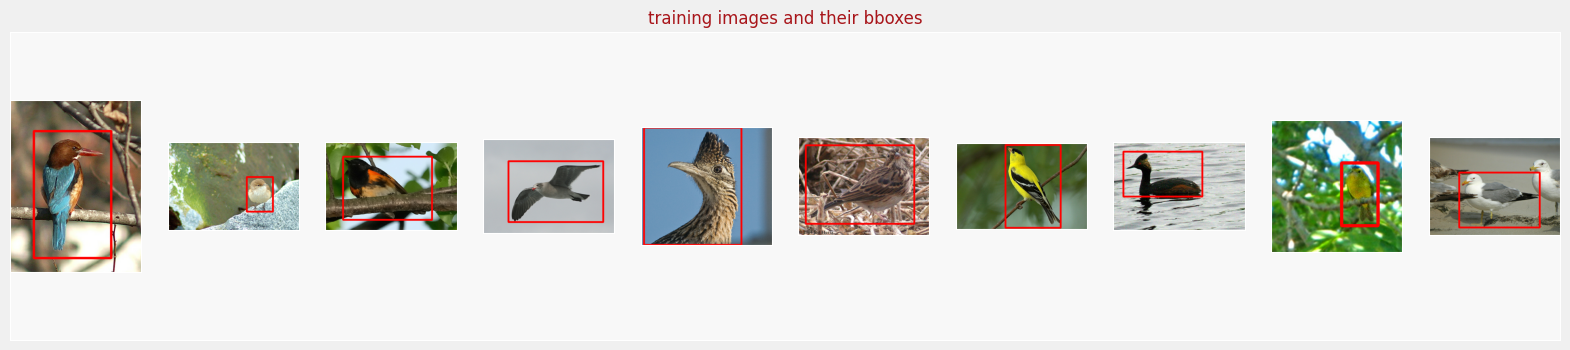

In [15]:
def get_visualization_training_dataset():
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

Visualize the **validation** images and their bounding boxes

2025-02-05 17:23:00.838910: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


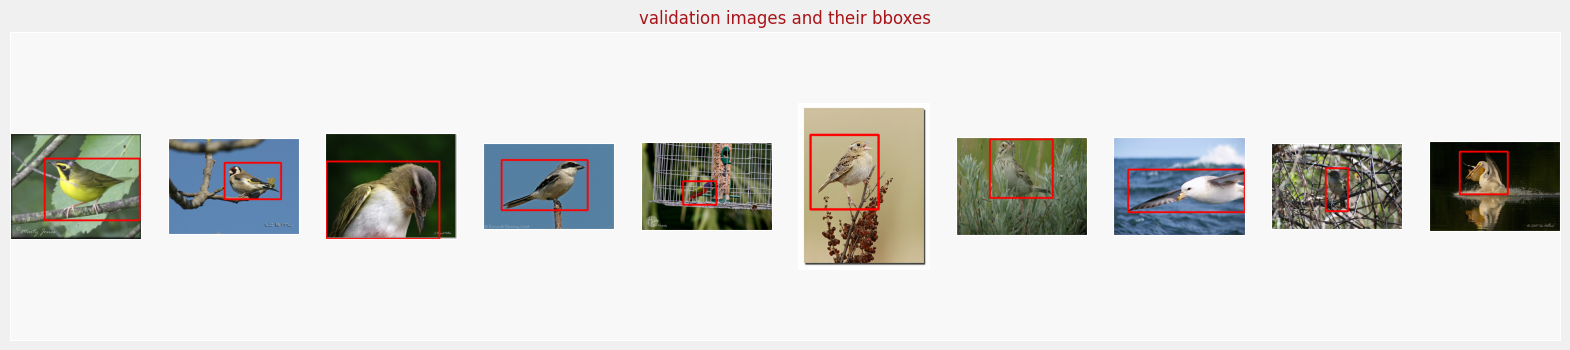

In [16]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

<a name="2-3"></a>
### 2.3 Load and prepare the datasets for the model

These next two functions read and prepare the datasets that you'll feed to the model.
- They use `read_image_tfds` to resize, and normalize each image and its bounding box label.
- They performs shuffling and batching.
- You'll use these functions to create `training_dataset` and `validation_dataset`, which you will give to the model that you're about to build.

In [17]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

<a name="3"></a>
## 3. Define the Network

Bounding box prediction is treated as a "regression" task, in that you want the model to output numerical values.

- You will be performing transfer learning with **MobileNet V2**.  The model architecture is available in TensorFlow Keras.
- You'll also use pretrained `'imagenet'` weights as a starting point for further training.  These weights are also readily available
- You will choose to retrain all layers of **MobileNet V2** along with the final classification layers.

**Note:** For the following exercises, please use the TensorFlow Keras Functional API (as opposed to the Sequential API).

<a name='ex-01'></a>
### Exercise 1

Please build a feature extractor using MobileNetV2.

- First, create an instance of the mobilenet version 2 model
  - Please check out the documentation for [MobileNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2)
  - Set the following parameters:
    - input_shape: (height, width, channel): input images have height and width of 224 by 224, and have red, green and blue channels.
    - include_top: you do not want to keep the "top" fully connected layer, since you will customize your model for the current task.
    - weights: Use the pre-trained 'imagenet' weights.
  
- Next, make the feature extractor for your specific inputs by passing the `inputs` into your mobilenet model.
    - For example, if you created a model object called `some_model` and have inputs stored in `x`, you'd invoke the model and pass in your inputs like this: `some_model(x)` to get the feature extractor for your given inputs `x`.

**Note**: please use mobilenet_v2 and not mobile_net or mobile_net_v3

In [18]:
def feature_extractor(inputs):
    ### YOUR CODE HERE ###

    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
            input_shape=(224,224,3),
            include_top=False,
            weights='imagenet',
        )


    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)


    ### END CODE HERE ###

    # return the feature_extractor
    return feature_extractor

<a name='ex-02'></a>
### Exercise 2

Next, you'll define the dense layers to be used by your model.

You'll be using the following layers
- [GlobalAveragePooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D): pools the `features`.
- [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten): flattens the pooled layer.
- [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): Add two dense layers:
    - A dense layer with 1024 neurons and a relu activation.
    - A dense layer following that with 512 neurons and a relu activation.
    
**Note**: Remember, please build the model using the Functional API syntax (as opposed to the Sequential API).

In [19]:
def dense_layers(features):
    ### YOUR CODE HERE ###

    # global average pooling 2d layer
    x = tf.keras.layers.GlobalAveragePooling2D()(features)

    # flatten layer
    x = tf.keras.layers.Flatten()(x)

    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024,activation='relu')(x)

    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512,activation='relu')(x)

    ### END CODE HERE ###

    return x

<a name='ex-03'></a>
### Exercise 3


Now you'll define a layer that outputs the bounding box predictions.
- You'll use a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer.
- Remember that you have _4 units_ in the output layer, corresponding to (xmin, ymin, xmax, ymax).
- The prediction layer follows the previous dense layer, which is passed into this function as the variable `x`.
- For grading purposes, please set the `name` parameter of this Dense layer to be `bounding_box'

In [20]:
def bounding_box_regression(x):
    ### YOUR CODE HERE ###

    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4,name='bounding_box')(x)

    ### END CODE HERE ###


    return bounding_box_regression_output

<a name='ex-04'></a>
### Exercise 4

Now, you'll use those functions that you have just defined above to construct the model.
- feature_extractor(inputs)
- dense_layers(features)
- bounding_box_regression(x)

Then you'll define the model object using [Model](https://www.tensorflow.org/s/results?q=Model).  Set the two parameters:
- inputs
- outputs

In [21]:
def final_model(inputs):
    ### YOUR CODE HERE ###

    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)

    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs = inputs, outputs = bounding_box_output)

    ### END CODE HERE ###


    return model

<a name='ex-05'></a>
### Exercise 5

Define the input layer, define the model, and then compile the model.
- inputs: define an [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input) layer
  - Set the `shape` parameter.  Check your definition of `feature_extractor` to see the expected dimensions of the input image.
- model: use the `final_model` function that you just defined to create the model.
- compile the model: Check the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model) documentation for how to compile the model.
  - Set the `optimizer` parameter to Stochastic Gradient Descent using [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
    - When using SGD, set the `momentum` to 0.9 and keep the default learning rate. (_**Note:** To avoid grading issues, please use `tf.keras.optimizers.SGD` instead of `tf.keras.optimizers.experimental.SGD`. We will remove this note once the grader has been updated to recognize the `experimental` module._).
  - Set the loss function of SGD to mean squared error (see the SGD documentation for an example of how to choose mean squared error loss).

In [22]:
def define_and_compile_model():

    ### YOUR CODE HERE ###

    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224,224,3))

    # create the model
    model = final_model(inputs)

    # compile your model
    model.compile(optimizer = tf.keras.optimizers.SGD(momentum = 0.9), loss='mse')

    ### END CODE HERE ###


    return model

Run the cell below to define your model and print the model summary.

In [23]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bounding_box (Dense)            │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

Your expected model summary:

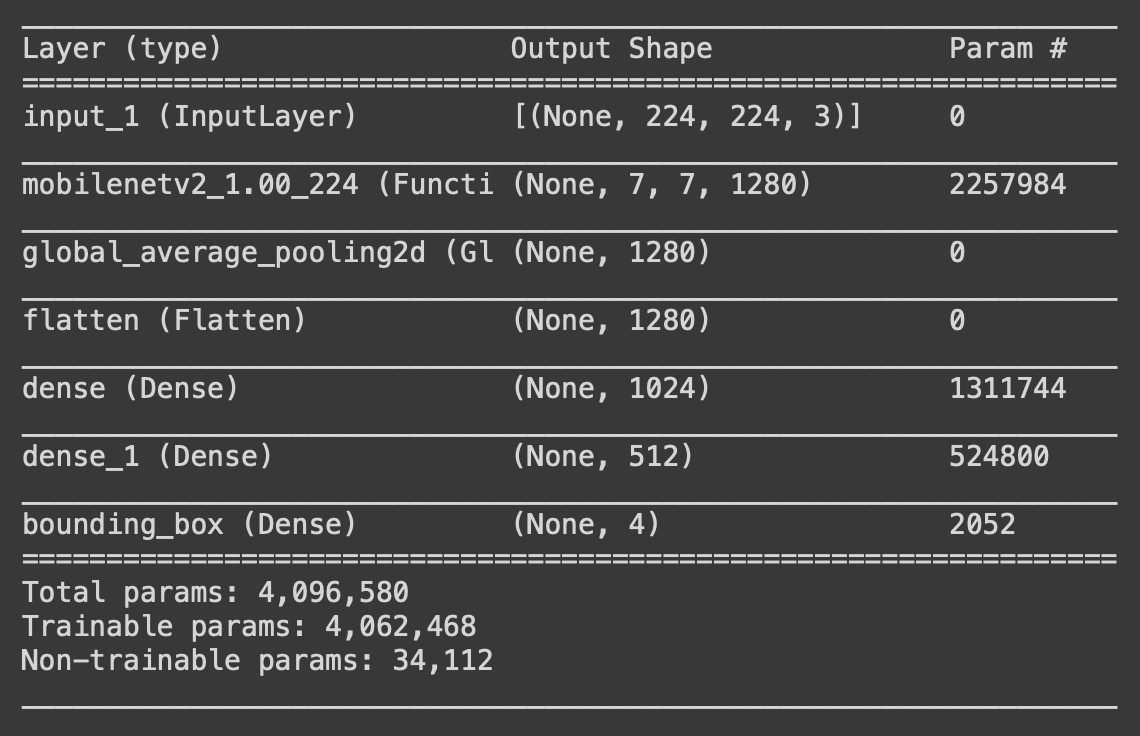

<a name='4'></a>
## Train the Model

<a name='4.1'></a>
### 4.1 Prepare to Train the Model

You'll fit the model here, but first you'll set some of the parameters that go into fitting the model.

- EPOCHS: You'll train the model for 50 epochs
- BATCH_SIZE: Set the `BATCH_SIZE` to an appropriate value. You can look at the ungraded labs from this week for some examples.
- length_of_training_dataset: this is the number of training examples.  You can find this value by getting the length of `visualization_training_dataset`.
  - Note: You won't be able to get the length of the object `training_dataset`. (You'll get an error message).
- length_of_validation_dataset: this is the number of validation examples.  You can find this value by getting the length of `visualization_validation_dataset`.
  - Note: You won't be able to get the length of the object `validation_dataset`.
- steps_per_epoch: This is the number of steps it will take to process all of the training data.  
  - If the number of training examples is not evenly divisible by the batch size, there will be one last batch that is not the full batch size.
  - Try to calculate the number steps it would take to train all the full batches plus one more batch containing the remaining training examples. There are a couples ways you can calculate this.
    - You can use regular division `/` and import `math` to use `math.ceil()` [Python math module docs](https://docs.python.org/3/library/math.html)
    - Alternatively, you can use `//` for integer division, `%` to check for a remainder after integer division, and an `if` statement.
  
- validation_steps: This is the number of steps it will take to process all of the validation data.  You can use similar calculations that you did for the step_per_epoch, but for the validation dataset.

<a name='ex-06'></a>
### Exercise 6

In [24]:
# You'll train 50 epochs
EPOCHS = 50

### START CODE HERE ###

# Choose a batch size
BATCH_SIZE = 32

# Get the length of the training set
length_of_training_dataset = len(visualization_training_dataset)

# Get the length of the validation set
length_of_validation_dataset = len(visualization_validation_dataset)

# Get the steps per epoch (may be a few lines of code)
steps_per_epoch = 6000// BATCH_SIZE

# get the validation steps (per epoch) (may be a few lines of code)
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

### END CODE HERE

<a name='4.2'></a>
### 4.2 Fit the model to the data


Check out the parameters that you can set to fit the [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).  Please set the following parameters.
- x: this can be a tuple of both the features and labels, as is the case here when using a tf.Data dataset.
  - Please use the variable returned from `get_training_dataset()`.
  - Note, don't set the `y` parameter when the `x` is already set to both the features and labels.
- steps_per_epoch: the number of steps to train in order to train on all examples in the training dataset.
- validation_data: this is a tuple of both the features and labels of the validation set.
  - Please use the variable returned from `get_validation_dataset()`
- validation_steps: teh number of steps to go through the validation set, batch by batch.
- epochs: the number of epochs.

If all goes well your model's training will start.

<a name='ex-07'></a>
### Exercise 7

In [25]:
### YOUR CODE HERE ####

# Fit the model, setting the parameters noted in the instructions above.
history =  model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS)

### END CODE HERE ###

Epoch 1/50


I0000 00:00:1738772589.635930    5955 service.cc:148] XLA service 0x7f591c013800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738772589.636546    5955 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-02-05 17:23:09.872032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738772590.440224    5955 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-05 17:23:11.558198: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5010_0', 244 bytes spill stores, 244 bytes spill loads

2025-02-05 17:23:11.561769: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5010', 228 

187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1424

2025-02-05 17:23:37.567433: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109888 bytes after encountering the first element of size 67109888 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-02-05 17:23:40.642880: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1159_0', 344 bytes spill stores, 520 bytes spill loads

2025-02-05 17:23:40.815974: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1166_0', 352 bytes spill stores, 448 bytes spill loads

2025-02-05 17:23:40.881942: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

187/187 ━━━━━━━━━━━━━━━━━━━━ 42s 106ms/step - loss: 0.1419 - val_loss: 0.1663
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0087 - val_loss: 0.0850
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0054 - val_loss: 0.0533
Epoch 4/50
 41/187 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0042

2025-02-05 17:24:16.138466: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 88/187 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0042

2025-02-05 17:24:19.212354: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


135/187 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0041

2025-02-05 17:24:22.308950: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0040

2025-02-05 17:24:25.369942: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0040 - val_loss: 0.0355
Epoch 5/50
 41/187 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0033

2025-02-05 17:24:30.572238: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 88/187 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0032

2025-02-05 17:24:33.622624: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


135/187 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0032

2025-02-05 17:24:36.721653: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


182/187 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0032

2025-02-05 17:24:39.808426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0032

2025-02-05 17:24:40.380009: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109888 bytes after encountering the first element of size 67109888 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 0.0032 - val_loss: 0.0283
Epoch 6/50
 42/187 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0028

2025-02-05 17:24:45.086657: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 89/187 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0028

2025-02-05 17:24:48.262198: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


136/187 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0028

2025-02-05 17:24:51.366039: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0028

2025-02-05 17:24:54.541498: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0028 - val_loss: 0.0235
Epoch 7/50
 42/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0026

2025-02-05 17:24:59.827743: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 89/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0026

2025-02-05 17:25:03.003763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


136/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0025

2025-02-05 17:25:06.172113: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


183/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0025

2025-02-05 17:25:09.339535: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0025 - val_loss: 0.0213
Epoch 8/50
 43/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0024

2025-02-05 17:25:14.701860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 90/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0024

2025-02-05 17:25:17.880791: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


137/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0024

2025-02-05 17:25:21.087230: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0024

2025-02-05 17:25:24.280383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0024 - val_loss: 0.0196
Epoch 9/50
 43/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0022

2025-02-05 17:25:29.566299: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


137/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0021

2025-02-05 17:25:35.906045: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


184/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0021

2025-02-05 17:25:39.104244: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0021 - val_loss: 0.0183
Epoch 10/50
 44/187 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0021 

2025-02-05 17:25:44.668331: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 91/187 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0021

2025-02-05 17:25:47.948572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


138/187 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0021

2025-02-05 17:25:51.156467: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0021

2025-02-05 17:25:54.340917: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0021 - val_loss: 0.0178
Epoch 11/50
 44/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0020

2025-02-05 17:25:59.614389: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 91/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0020

2025-02-05 17:26:02.819518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


138/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0020

2025-02-05 17:26:05.996717: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


185/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0020

2025-02-05 17:26:09.191892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0020 - val_loss: 0.0173
Epoch 12/50
 45/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0019

2025-02-05 17:26:14.523634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 92/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0019

2025-02-05 17:26:17.711860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


139/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0019

2025-02-05 17:26:20.892935: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0019

2025-02-05 17:26:24.071391: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0019 - val_loss: 0.0166
Epoch 13/50
 45/187 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0017

2025-02-05 17:26:29.643741: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 92/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0017

2025-02-05 17:26:32.810135: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


139/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0018

2025-02-05 17:26:36.016643: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


186/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0018

2025-02-05 17:26:39.195901: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0018 - val_loss: 0.0162
Epoch 14/50
 46/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0017

2025-02-05 17:26:44.826591: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 93/187 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0017

2025-02-05 17:26:47.983349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/187 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0017

2025-02-05 17:26:51.110810: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0017

2025-02-05 17:26:54.183737: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0017 - val_loss: 0.0162
Epoch 15/50
 46/187 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0018

2025-02-05 17:26:59.487402: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 93/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0018

2025-02-05 17:27:02.682242: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


140/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0018

2025-02-05 17:27:05.906308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0017

2025-02-05 17:27:09.009940: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0017 - val_loss: 0.0157
Epoch 16/50
 47/187 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0017

2025-02-05 17:27:14.434010: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 94/187 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0016

2025-02-05 17:27:17.730888: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


141/187 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0016

2025-02-05 17:27:20.961477: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0016

2025-02-05 17:27:24.175015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0016 - val_loss: 0.0156
Epoch 17/50
 47/187 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0016

2025-02-05 17:27:29.385093: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 94/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0016

2025-02-05 17:27:32.613525: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


141/187 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0016

2025-02-05 17:27:35.926929: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0016

2025-02-05 17:27:39.105772: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0016 - val_loss: 0.0155
Epoch 18/50
 48/187 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0015

2025-02-05 17:27:44.580826: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 95/187 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0015

2025-02-05 17:27:47.858536: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


142/187 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0015

2025-02-05 17:27:51.037661: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0015

2025-02-05 17:27:54.324548: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0015 - val_loss: 0.0152
Epoch 19/50
 48/187 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0014

2025-02-05 17:27:59.829518: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 95/187 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0014

2025-02-05 17:28:03.017109: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


142/187 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0015

2025-02-05 17:28:06.166338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0015

2025-02-05 17:28:09.338917: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-02-05 17:28:10.490233: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 592149 bytes after encountering the first element of size 592149 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0015 - val_loss: 0.0152
Epoch 20/50
 49/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0015

2025-02-05 17:28:14.671088: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 96/187 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0015

2025-02-05 17:28:17.792059: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/187 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0015

2025-02-05 17:28:20.955315: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0015 - val_loss: 0.0149
Epoch 21/50
  3/187 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0017

2025-02-05 17:28:26.584758: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 50/187 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0015

2025-02-05 17:28:29.682560: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 96/187 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0014

2025-02-05 17:28:32.874307: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


143/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0014

2025-02-05 17:28:36.056060: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0014 - val_loss: 0.0148
Epoch 22/50
  3/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0014

2025-02-05 17:28:41.411491: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 50/187 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0013

2025-02-05 17:28:44.580363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 97/187 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0014

2025-02-05 17:28:47.714064: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


144/187 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0014

2025-02-05 17:28:50.838598: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0014 - val_loss: 0.0148
Epoch 23/50
  4/187 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0014

2025-02-05 17:28:56.111383: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 50/187 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.0014

2025-02-05 17:28:59.151197: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 97/187 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0014

2025-02-05 17:29:02.276546: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


144/187 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014

2025-02-05 17:29:05.377077: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 0.0014 - val_loss: 0.0147
Epoch 24/50
  5/187 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0017

2025-02-05 17:29:10.674858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 51/187 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0014

2025-02-05 17:29:13.732890: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 98/187 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - loss: 0.0014

2025-02-05 17:29:16.827094: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


145/187 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0014

2025-02-05 17:29:19.950886: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0014 - val_loss: 0.0146
Epoch 25/50
  5/187 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0015

2025-02-05 17:29:25.275303: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 51/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0013

2025-02-05 17:29:28.404569: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 98/187 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0013

2025-02-05 17:29:31.707015: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


145/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0013

2025-02-05 17:29:34.922258: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0013 - val_loss: 0.0145
Epoch 26/50
  5/187 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0013

2025-02-05 17:29:40.307787: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 52/187 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0012

2025-02-05 17:29:43.428096: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 99/187 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0012

2025-02-05 17:29:46.587080: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


146/187 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0012

2025-02-05 17:29:49.741894: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0012 - val_loss: 0.0144
Epoch 27/50
  6/187 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - loss: 0.0013

2025-02-05 17:29:54.980375: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 52/187 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.0013

2025-02-05 17:29:58.046366: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 99/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0013

2025-02-05 17:30:01.304384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


146/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0012

2025-02-05 17:30:04.462511: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0012 - val_loss: 0.0143
Epoch 28/50
  6/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0011   

2025-02-05 17:30:09.756781: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 53/187 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0012

2025-02-05 17:30:12.985795: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0012

2025-02-05 17:30:16.156877: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


147/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0012

2025-02-05 17:30:19.289621: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0012 - val_loss: 0.0143
Epoch 29/50
  7/187 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0015

2025-02-05 17:30:24.567066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 53/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0013

2025-02-05 17:30:27.690085: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


100/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0013

2025-02-05 17:30:30.933567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


147/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0013

2025-02-05 17:30:34.163511: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.0013 - val_loss: 0.0141
Epoch 30/50
  7/187 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - loss: 0.0013

2025-02-05 17:30:39.933513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 54/187 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0012

2025-02-05 17:30:43.092340: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


101/187 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0012

2025-02-05 17:30:46.287297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


148/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0012

2025-02-05 17:30:49.521034: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 0.0012 - val_loss: 0.0141
Epoch 31/50
  8/187 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0010

2025-02-05 17:30:54.804187: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 54/187 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0011

2025-02-05 17:30:57.971779: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


101/187 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0011

2025-02-05 17:31:01.096339: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


148/187 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0012

2025-02-05 17:31:04.239297: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 0.0012 - val_loss: 0.0140
Epoch 32/50
  8/187 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0014

2025-02-05 17:31:09.472310: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 55/187 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0012

2025-02-05 17:31:12.614557: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


102/187 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0012

2025-02-05 17:31:15.806789: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


149/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0012

2025-02-05 17:31:19.088830: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0012 - val_loss: 0.0139
Epoch 33/50
  9/187 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0012

2025-02-05 17:31:24.465769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 55/187 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0011

2025-02-05 17:31:27.617766: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


102/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0012

2025-02-05 17:31:30.831160: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


149/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0012

2025-02-05 17:31:34.134715: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0012 - val_loss: 0.0139
Epoch 34/50
  9/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0013

2025-02-05 17:31:39.617065: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 56/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0012

2025-02-05 17:31:42.844909: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0012

2025-02-05 17:31:46.031356: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


150/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0012

2025-02-05 17:31:49.247671: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0012 - val_loss: 0.0139
Epoch 35/50
 10/187 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - loss: 0.0011

2025-02-05 17:31:54.793121: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 56/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0011

2025-02-05 17:31:57.959790: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


103/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0011

2025-02-05 17:32:01.176576: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


150/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0011

2025-02-05 17:32:04.364480: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0011 - val_loss: 0.0138
Epoch 36/50
 10/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0011

2025-02-05 17:32:09.822909: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 57/187 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0011

2025-02-05 17:32:13.108553: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


104/187 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0011

2025-02-05 17:32:16.417679: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


151/187 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0011

2025-02-05 17:32:19.630918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.0011 - val_loss: 0.0138
Epoch 37/50
 11/187 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 9.4772e-04

2025-02-05 17:32:25.199424: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 57/187 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 0.0010

2025-02-05 17:32:28.420349: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


104/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0010

2025-02-05 17:32:31.584293: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


151/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0010

2025-02-05 17:32:34.798304: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0010 - val_loss: 0.0137
Epoch 38/50
 11/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 9.3309e-04

2025-02-05 17:32:40.348774: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 58/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0010

2025-02-05 17:32:43.569565: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


105/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0011

2025-02-05 17:32:46.832969: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


152/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0011

2025-02-05 17:32:50.063125: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0011 - val_loss: 0.0137
Epoch 39/50
 12/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0011

2025-02-05 17:32:55.512605: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 58/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0010

2025-02-05 17:32:58.681941: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


105/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0010

2025-02-05 17:33:01.945099: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


152/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0010

2025-02-05 17:33:05.151503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 0.0010 - val_loss: 0.0136
Epoch 40/50
 12/187 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - loss: 0.0010

2025-02-05 17:33:10.542410: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 59/187 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0010

2025-02-05 17:33:13.852446: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


106/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0010

2025-02-05 17:33:17.064905: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


153/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0010

2025-02-05 17:33:20.265601: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0010 - val_loss: 0.0136
Epoch 41/50
 13/187 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 9.7797e-04

2025-02-05 17:33:25.840324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 59/187 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0010

2025-02-05 17:33:29.160314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


106/187 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0010

2025-02-05 17:33:32.404435: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


153/187 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0010

2025-02-05 17:33:35.674835: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - loss: 0.0010 - val_loss: 0.0135
Epoch 42/50
  3/187 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - loss: 7.9848e-04

2025-02-05 17:33:40.507858: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 592149 bytes after encountering the first element of size 592149 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 13/187 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.0011

2025-02-05 17:33:41.237860: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 60/187 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0010

2025-02-05 17:33:44.655958: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


107/187 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0010

2025-02-05 17:33:47.945296: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


154/187 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0010

2025-02-05 17:33:51.140685: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.0010 - val_loss: 0.0134
Epoch 43/50
 14/187 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 9.8941e-04

2025-02-05 17:33:56.706503: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 60/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 9.8095e-04

2025-02-05 17:33:59.867286: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


107/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.8602e-04

2025-02-05 17:34:03.099715: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


154/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 9.8943e-04

2025-02-05 17:34:06.348615: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 9.9215e-04 - val_loss: 0.0134
Epoch 44/50
 14/187 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0010

2025-02-05 17:34:11.768804: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 61/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 9.9682e-04

2025-02-05 17:34:15.010878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


108/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.8897e-04

2025-02-05 17:34:18.256513: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


155/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 9.8517e-04

2025-02-05 17:34:21.473155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 9.8182e-04 - val_loss: 0.0133
Epoch 45/50
 15/187 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0011

2025-02-05 17:34:26.863257: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 61/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0010

2025-02-05 17:34:30.045450: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


108/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.9728e-04

2025-02-05 17:34:33.270430: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


155/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 9.9609e-04

2025-02-05 17:34:36.537019: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 9.9454e-04 - val_loss: 0.0133
Epoch 46/50
 15/187 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 9.0862e-04

2025-02-05 17:34:41.989479: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 62/187 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 9.3412e-04

2025-02-05 17:34:45.216925: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


109/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 9.3837e-04

2025-02-05 17:34:48.425853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


156/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 9.4016e-04

2025-02-05 17:34:51.628747: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 9.4433e-04 - val_loss: 0.0133
Epoch 47/50
 16/187 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0011

2025-02-05 17:34:57.041579: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 62/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.0010

2025-02-05 17:35:00.219782: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


109/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0010

2025-02-05 17:35:03.413844: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


156/187 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0010

2025-02-05 17:35:06.646616: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - loss: 0.0010 - val_loss: 0.0133
Epoch 48/50
 16/187 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 9.4801e-04

2025-02-05 17:35:12.128102: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 63/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 9.6982e-04

2025-02-05 17:35:15.354054: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


110/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.6666e-04

2025-02-05 17:35:18.577880: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


157/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 9.6590e-04

2025-02-05 17:35:21.763294: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 9.6497e-04 - val_loss: 0.0132
Epoch 49/50
 17/187 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0010

2025-02-05 17:35:27.159426: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 63/187 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 9.7480e-04

2025-02-05 17:35:30.312504: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


110/187 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 9.6656e-04

2025-02-05 17:35:33.538415: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


157/187 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 9.6268e-04

2025-02-05 17:35:36.760487: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 9.5997e-04 - val_loss: 0.0132
Epoch 50/50
 17/187 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 8.7333e-04

2025-02-05 17:35:42.159512: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


 64/187 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 9.2724e-04

2025-02-05 17:35:45.399166: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


111/187 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 9.3109e-04

2025-02-05 17:35:48.613634: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


158/187 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 9.3354e-04

2025-02-05 17:35:51.809320: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 666157 bytes after encountering the first element of size 666157 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


187/187 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - loss: 9.3321e-04 - val_loss: 0.0132


<a name='5'></a>
## 5. Validate the Model

<a name='5-1'></a>
### 5.1 Loss

You can now evaluate your trained model's performance by checking its loss value on the validation set.

In [26]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

 1/95 ━━━━━━━━━━━━━━━━━━━━ 27s 294ms/step - loss: 0.0123

2025-02-05 17:36:31.405793: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 67109888 bytes after encountering the first element of size 67109888 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0131
Loss:  0.013150440528988838


<a name='5-2'></a>
### 5.2 Plot Loss Function

You can also plot the loss metrics.

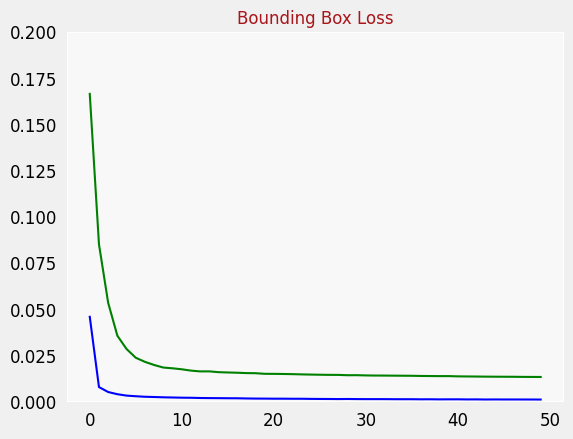

In [27]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

<a name='5-3'></a>
### 5.3 Evaluate performance using IoU

You can see how well your model predicts bounding boxes on the validation set by calculating the Intersection-over-union (IoU) score for each image.

- You'll find the IoU calculation implemented for you.
- Predict on the validation set of images.
- Apply the `intersection_over_union` on these predicted bounding boxes.

In [28]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images.astype('float32'))


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

2025-02-05 17:36:43.630797: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153_0', 112 bytes spill stores, 144 bytes spill loads

2025-02-05 17:36:43.834672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153', 16 bytes spill stores, 16 bytes spill loads

2025-02-05 17:36:43.871188: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153', 228 bytes spill stores, 228 bytes spill loads

2025-02-05 17:36:44.233058: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1160_0', 88 bytes spill stores, 120 bytes spill loads

2025-02-05 17:36:44.531161: I external/local_xla/xl

11/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-02-05 17:36:49.018321: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153_0', 344 bytes spill stores, 520 bytes spill loads

2025-02-05 17:36:49.039208: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153', 16 bytes spill stores, 16 bytes spill loads

2025-02-05 17:36:49.098367: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1160', 4 bytes spill stores, 4 bytes spill loads

2025-02-05 17:36:49.107462: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1153', 40 bytes spill stores, 40 bytes spill loads

2025-02-05 17:36:49.181745: I external/local_xla/xla/strea

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 298ms/step
Number of predictions where iou > threshold(0.5): 297
Number of predictions where iou < threshold(0.5): 203


<a name='6'></a>
## 6. Visualize Predictions

Lastly, you'll plot the predicted and ground truth bounding boxes for a random set of images and visually see how well you did!


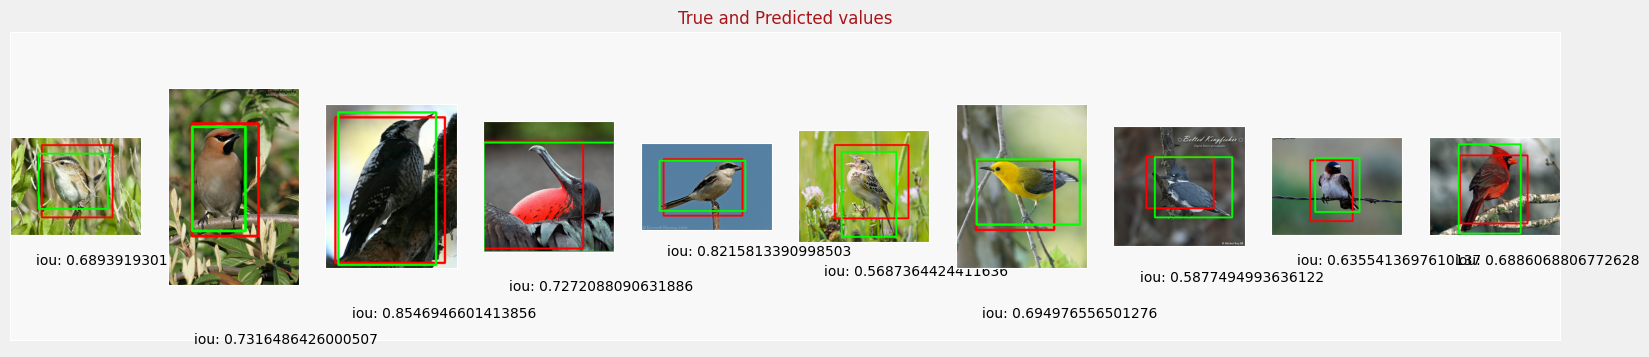

In [29]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)

## 7. Save the Model

Once you're satisfied with the results, you can save your model and upload it to the grader in Coursera. Please run all succeeding cells to ensure that you will have a gradable submission. Otherwise, you might get this error message:

`There was a problem grading your submission. Check stderr for more details.`

First, save the model file in your Colab workspace.

In [30]:
# Save the model you just trained
model.save("birds.keras")

Please look for `birds.keras` in the File Explorer on the left and download it. Then, go back to the Coursera classroom and upload it to the `My Submissions` tab of the Week 1 assignment. Alternatively, you can also use the cell below to download the model.



In [ ]:
# You can also use this cell as a shortcut for downloading your model
from google.colab import files
files.download("birds.keras")

**Congratulations on completing this assignment on predicting bounding boxes!**